In [ ]:
%%writefile Archivo_Datos.c
#include<stdio.h>
#include<stdlib.h>
#include<time.h>
// ---> argv[1]: Nombre del archivo a generar <---
// ---> argv[2]: numero de datos a generar    <---
int main(int argc, char*argv[]){
  FILE *fp;
  int n,*datos, i;
  
  n = atoi(argv[2]);
  fp = fopen(argv[1], "w");
  if(fp){
    srand(time(NULL));
    fprintf(fp,"%d\n",n);
    for(i=0;i<n;i++)
      fprintf(fp,"%d\n",rand()%100);
    
    fclose(fp);
  }
  
	return 0;
}

Writing Archivo_Datos.c


In [ ]:
%%script bash
echo "Genera Archivo de Datos"
gcc Archivo_Datos.c -o Archivo_Datos -lm
./Archivo_Datos datos.dat 100

Genera Archivo de Datos


In [ ]:
%%writefile QuickSort.c
#include <stdlib.h>
#include <stdio.h>
#include <sys/time.h>

float time_diff(struct timeval *start, struct timeval *end){
    return (end->tv_sec - start->tv_sec) + 1e-6*(end->tv_usec - start->tv_usec);
}

int read_array(char* fname, int **arr) {
  FILE *myFile;
  int i,n;

  myFile = fopen(fname, "r");
  fscanf(myFile, "%i\n", &n); // <--- primero lee el num de datos a ordenar

  *arr = (int *) malloc(n*sizeof(int));
  if (*arr == NULL){printf("Memoria insuficiente\n");return 1;}

  for (i=0; i < n; i++) fscanf(myFile, "%i\n", (*arr)+i);

  return n;
}

int compare(const void *_a, const void *_b) {
        int *a, *b;        
        a = (int *) _a;
        b = (int *) _b;
        return (*a - *b);
}

//  ■■■■
int main(int argc, char**argv) {
  FILE *myFile;
  int n, chunksize, i;
  int *Arreglo;

  struct timeval start;
  struct timeval end;
  gettimeofday(&start,NULL);

  myFile = fopen(argv[1], "r");
   if(!myFile){
    printf("ERROR: No se pudo abrir el archivo para lectura <%s>",argv[1]);
    return -1;
  }

  fscanf(myFile, "%i\n", &n); // numero de datos a leer
  printf("cantidad de números a ordenar: %i",n);

  Arreglo = (int*) malloc(n*sizeof(int));

  for (i=0; i < n; i++)
    fscanf(myFile, "%i\n", (Arreglo)+i);
  

    /*printf("\nArreglo Desordenado = {");
    for(i=0;i<n;i++)
      printf("%d, ", Arreglo[i]);
    printf("}");*/

  // ------aqui va el procesamiento a realizar con los datos

  qsort(Arreglo, n, sizeof(int), &compare);

    /*printf("\nArreglo ordenado = {");
    for(i=0;i<n;i++)
      printf("%d, ",Arreglo[i]);
    printf("}");*/

  gettimeofday(&end,NULL);

  printf("\nTiempo ejecutado en %f segundos", time_diff(&start, &end));
  
  free(Arreglo);
  return 0;
}

Writing QuickSort.c


In [ ]:
%%script bash
echo "Ordenamiento Rápido"
gcc QuickSort.c -o quicksort -lm
./quicksort datos.dat

Ordenamiento Rápido
cantidad de números a ordenar: 100
Tiempo ejecutado en 0.000100 segundos

In [ ]:
%%writefile header.h
int compare(const void *_a, const void *_b) {
        int *a, *b;        
        a = (int *) _a;
        b = (int *) _b;
        return (*a - *b);
}

int read_array(char* fname, int **arr) {
    FILE *myFile;
    unsigned int i, n;

    myFile = fopen(fname, "r");           
    if(   !myFile   ) {   
      printf("\nERROR: No se pudo abrir el archivo para lectura %s\n\n",fname);  
      MPI_Abort(MPI_COMM_WORLD, 99); 
      }

    fscanf(myFile, "%i\n", &n); // numero de datoss a leer

    *arr = (int *) malloc(n*sizeof(int)); 
      if (*arr == NULL) { 
        printf("Memoria insuficiente\n"); 
        MPI_Abort(MPI_COMM_WORLD, 99); return 0; 
      }

    for ( i=0; i < n; i++)
        fscanf(myFile, "%i\n", (*arr)+i);

    fclose(myFile);

    return n;
}

void separaDatos_Pivote(int *bloque,unsigned int *cuantosMn,int **bloqueMenor, unsigned int *cuantosMy,int **bloqueMayor, int pivote, unsigned int n, int iteracion, int id){
	int i;
    *bloqueMenor = NULL;
    *bloqueMayor = NULL;

    *cuantosMn = 0;
    i=0;
	while(bloque[i]<pivote && i<n){
		(*cuantosMn) ++;		
        i++;
    }   

    if(*cuantosMn){
        *bloqueMenor =(int *)malloc((*cuantosMn)*sizeof(int));  
        if(*bloqueMenor==NULL){
          printf("\n(%d) ERROR: No hay memoria (*bloqueMenor)\n\n",iteracion);  
          MPI_Abort(MPI_COMM_WORLD, 99);
          }
    

        for(i=0;i<*cuantosMn;i++)
            (*bloqueMenor)[i] = bloque[i];
    }
    
    *cuantosMy = n-(*cuantosMn);
    if(*cuantosMy){
        *bloqueMayor =(int *)malloc((*cuantosMy)*sizeof(int));  
        if(*bloqueMayor==NULL){
          printf("\n(%d) ERROR: No hay memoria (*bloqueMayor)\n\n",iteracion);  
          MPI_Abort(MPI_COMM_WORLD, 99);
          }

        for(i=*cuantosMn;i<n;i++)
            (*bloqueMayor)[i-*cuantosMn]=bloque[i];
    }

	return;
}

int* mezclar_bloques(int *bloque1,int *bloque2,unsigned int n1,unsigned int n2){
    int *aux;

    aux = (int *)malloc((n1+n2)*sizeof(int));   if(aux==NULL){printf("\n ERROR: No hay memoria (aux)\n\n");  
    MPI_Abort(MPI_COMM_WORLD, 99);
    }
    
    unsigned int a = 0; // Indice que recorre el bloque1
    unsigned int b = 0; // Indice que recorre el bloque2
    unsigned int i = 0;

    while (a < n1 && b < n2){
        if(bloque1[a] <= bloque2[b]){
            aux[i] = bloque1[a];
            a++;
        }else{
            aux[i] = bloque2[b];
            b++;
        }
        i++;
    }

    // Si el indice b llegó al final de su arreglo
    if(a == n1){
        // Asignamos los numeros restantes en el bloque2
        while(b < n2){
            aux[i] = bloque2[b];
            b++;
            i++;
        }
    }else   // Si el indice b llegó al final de su arreglo
        // Asignamos los numeros restantes en el bloque1
        while(a < n1){
            aux[i] = bloque1[a];
            a++;
            i++;
        }       

    return aux;
}

Writing header.h


In [ ]:
%%writefile hyperquicksort1D.c
#include "mpi.h"
#include <stdio.h>
#include <stdlib.h>
#include <math.h>

#include "header.h"

#define BLOCK_LOW(id,p,n) ((id)*(n)/(p))
#define BLOCK_HIGH(id,p,n) (BLOCK_LOW((id)+1,p,n)-1)
#define BLOCK_SIZE(id,p,n)(BLOCK_HIGH(id,p,n)-BLOCK_LOW(id,p,n)+1)


//  ¦¦¦¦
int main(int argc,char *argv[]){
    double elapsed_time;	
    int          *Arreglo, *bloque, *bloqueMenor, *bloqueMayor, *bloqueAux, pivote, partner, nprocesos_minimo;
    int          idCart, idCart2, p, pCart, i, j, id, root;	    
    int          ND, *dimensiones, *periodicos;
    int          *cambiosDedimension, *cambiosDedimension2; 
    unsigned int nt,cuantosMn, cuantosMy, cuantosMn2, cuantosMy2, ndatos_local;
    unsigned int *sendcounts,*sdispls, *recvcounts, *displs;
    MPI_Comm     comm_topologia_hipercubo, comm_sub_hipercubo, comm_sub_hipercubo2;

    MPI_Init(&argc,&argv);
    MPI_Comm_rank(MPI_COMM_WORLD,&id);
    MPI_Comm_size(MPI_COMM_WORLD,&p);
    elapsed_time = - MPI_Wtime();

    if(argc!=3){
		if(id==0) 
    printf("ERROR: mpirun -np <NP> ./hiperquicksort nombre_archivo <NumDimensiones> \n");
		MPI_Abort(MPI_COMM_WORLD,1);
        return EXIT_SUCCESS;
	}

    ND = atoi(argv[2]);

    dimensiones = (int*) malloc(ND*sizeof(int));    
    if( dimensiones == NULL ){ 
      printf("ERROR: Memoria insuficiente! (dimensiones)\n");  
      MPI_Abort(MPI_COMM_WORLD, 99); 
    }
    periodicos = (int*) malloc(ND*sizeof(int));     
    if( periodicos  == NULL ){ 
      printf("ERROR: Memoria insuficiente! (periodicos)\n");   
      MPI_Abort(MPI_COMM_WORLD, 99); 
      }

    nprocesos_minimo = 1; 
    for(i=0;i<ND;i++){
        dimensiones[i]    = 2;
        periodicos[i]     = 0;
        nprocesos_minimo *= 2;
    }

    if( p < nprocesos_minimo ){
        printf( "\nERROR: Se requieren al menos %d procesos \n\n", nprocesos_minimo );
        MPI_Abort( MPI_COMM_WORLD, 99 ); 
    }

    MPI_Cart_create(MPI_COMM_WORLD,ND,dimensiones,periodicos,1,&comm_topologia_hipercubo);

    if(comm_topologia_hipercubo!=MPI_COMM_NULL){
        MPI_Comm_rank(comm_topologia_hipercubo, &idCart);
        MPI_Comm_size(comm_topologia_hipercubo, &pCart);
        root = 0;
        if (idCart == root){ // Lee los datos del archivo
            nt = read_array(argv[1], &Arreglo);      
        }

        MPI_Bcast(&nt, 1, MPI_UNSIGNED, root, comm_topologia_hipercubo); 

        // ----  El root envía los datos que le corresponden a cada proceso
        // ----   No necesariamente le va a enviar el mismo numero de datos a cada proceso, por eso se requiere MPI_Scatterv  

        ndatos_local = BLOCK_SIZE(idCart,pCart,nt); 

        bloque     = (int*) malloc(ndatos_local*sizeof(int));               
        if( bloque     == NULL ){ printf("ERROR: Memoria insuficiente! (bloque)\n");       
        MPI_Abort(comm_topologia_hipercubo, 99); 
        } 
        sendcounts = (unsigned int*) malloc(pCart*sizeof(unsigned int));    
        if( sendcounts == NULL ){ 
          printf("ERROR: Memoria insuficiente! (sendcounts)\n");    
          MPI_Abort(comm_topologia_hipercubo, 99);  
          } 
        sdispls    = (unsigned int*) malloc(pCart*sizeof(unsigned int));    
        if( sdispls    == NULL ){ 
          printf("ERROR: Memoria insuficiente! (sdispls)\n");       
          MPI_Abort(comm_topologia_hipercubo, 99); 
          } 

        if( idCart == root ){
            for( i = 0 ; i < pCart; i++ )
                sendcounts[i]=BLOCK_SIZE(i,pCart,nt);
            
            sdispls[0] = 0;
            for( i = 1 ; i < pCart; i++ )  
                sdispls[i] = sdispls[i-1] + sendcounts[i-1];
        }

        MPI_Scatterv( Arreglo, sendcounts, sdispls, MPI_INT, bloque, ndatos_local, MPI_INT, root, comm_topologia_hipercubo );

        // Cada proceso ordena localmente su bloque
        qsort(bloque, ndatos_local, sizeof(int), compare);


        // seleccionar un pivote y mandarlo a todo el comunicador
        if( idCart == root ){
            if( ndatos_local % 2 == 0 ) pivote = (bloque[ndatos_local/2]+bloque[(ndatos_local-2)/2])/2; // el promedio de los dos valores medios
            else                        pivote = bloque[ndatos_local/2];
        }

        MPI_Bcast (&pivote, 1, MPI_INT, root, comm_topologia_hipercubo );
        separaDatos_Pivote( bloque, &cuantosMn, &bloqueMenor, &cuantosMy, &bloqueMayor, pivote, ndatos_local, 0 , idCart);      

        cambiosDedimension  = (int*) malloc(ND*sizeof(int));  
        if( cambiosDedimension  == NULL ){ 
          printf("ERROR: Memoria insuficiente! (cambiosDedimension)\n"); 
          MPI_Abort(MPI_COMM_WORLD, 99); 
          }
        cambiosDedimension2 = (int*) malloc(ND*sizeof(int));  
        if( cambiosDedimension2 == NULL ){ 
          printf("ERROR: Memoria insuficiente! (cambiosDedimension2)\n"); 
          MPI_Abort(MPI_COMM_WORLD, 99); 
          }

        for( i = 0 ; i < ND; i++ ){
            for(j=0;j<ND;j++){
                if(j==i){
                    cambiosDedimension[j]=1;				
                    cambiosDedimension2[j]=0;
                }else{
                    cambiosDedimension[j]=0;
                    if(i>j) cambiosDedimension2[j]=0;				
                    else    cambiosDedimension2[j]=1;
                }
            }

            MPI_Cart_sub(comm_topologia_hipercubo, cambiosDedimension, &comm_sub_hipercubo);	// se determina el partner	
            MPI_Comm_rank(comm_sub_hipercubo, &idCart);           

            if(idCart==0){	// envio los mayores al partner y recibo los menores del partner
                partner = 1;			
                MPI_Send(  &cuantosMy, 1, MPI_UNSIGNED, partner, 0, comm_sub_hipercubo          );                
                if( cuantosMy != 0 ){
                    MPI_Send(bloqueMayor, cuantosMy, MPI_INT, partner, 3, comm_sub_hipercubo);
                    free(bloqueMayor);
                }

                MPI_Recv( &cuantosMn2, 1, MPI_UNSIGNED, partner, 1, comm_sub_hipercubo, MPI_STATUS_IGNORE );				
                if( cuantosMn2 != 0 ){				
                    bloqueAux=(int *)malloc(cuantosMn2*sizeof(int));        
                    if( bloqueAux  == NULL ){ 
                      printf("ERROR: Memoria insuficiente! (bloqueAux)\n"); 
                      MPI_Abort(MPI_COMM_WORLD, 99); 
                      }		
                    MPI_Recv(bloqueAux, cuantosMn2, MPI_INT, partner, 4, comm_sub_hipercubo, MPI_STATUS_IGNORE);
                }

                if( ndatos_local != 0 )	free(bloque);

                bloque = mezclar_bloques( bloqueMenor, bloqueAux, cuantosMn, cuantosMn2);
                ndatos_local = cuantosMn + cuantosMn2;

                if( cuantosMn  != 0 ) free(bloqueMenor);				
                if( cuantosMn2 != 0 ) free(bloqueAux);
            }else{			
                partner = 0;	
                MPI_Send(&cuantosMn,  1, MPI_UNSIGNED, partner, 1, comm_sub_hipercubo);                
                if(cuantosMn!=0){
                    MPI_Send(bloqueMenor, cuantosMn, MPI_INT, partner, 4, comm_sub_hipercubo);
                    free(bloqueMenor);
                }

                MPI_Recv(&cuantosMy2, 1, MPI_UNSIGNED, partner, 0, comm_sub_hipercubo,  MPI_STATUS_IGNORE);				
                if(cuantosMy2!=0){				
                    bloqueAux=(int *)malloc(cuantosMy2*sizeof(int));        
                    if( bloqueAux  == NULL ){ 
                      printf("ERROR: Memoria insuficiente! (bloqueAux)\n"); 
                      MPI_Abort(MPI_COMM_WORLD, 99); 
                      }	
                    MPI_Recv(bloqueAux, cuantosMy2, MPI_INT, partner, 3, comm_sub_hipercubo,  MPI_STATUS_IGNORE);
                }			
                if( ndatos_local != 0 )	free(bloque);	
                						
                bloque = mezclar_bloques(bloqueMayor, bloqueAux, cuantosMy, cuantosMy2);
                ndatos_local = cuantosMy + cuantosMy2;

                if( cuantosMy  != 0 ) free(bloqueMayor);
                if( cuantosMy2 != 0 ) free(bloqueAux);
            }
        
            if(i!=ND-1){ // se divide en subcomunicadores
                MPI_Cart_sub( comm_topologia_hipercubo, cambiosDedimension2, &comm_sub_hipercubo2 );		
                MPI_Comm_rank( comm_sub_hipercubo2, &idCart2 );
                if(idCart2==0){
                    if( ndatos_local > 0 ){
                        if(ndatos_local%2==0) pivote = (bloque[ndatos_local/2]+bloque[(ndatos_local-2)/2])/2; // el promedio de los dos valores medios
                        else                  pivote = bloque[ndatos_local/2];
                    }else{
                        printf("\n ERROR: El root se quedó sin datos :( <==== \n\n");
                        MPI_Abort(MPI_COMM_WORLD, 99);
                    }
                }				
                MPI_Bcast(&pivote,1,MPI_INT,0,comm_sub_hipercubo2);	
                separaDatos_Pivote( bloque, &cuantosMn, &bloqueMenor, &cuantosMy, &bloqueMayor, pivote, ndatos_local, i , idCart);
            }	       
        }

        if(ND>1){
            MPI_Comm_free(&comm_sub_hipercubo);
            MPI_Comm_free(&comm_sub_hipercubo2);
        }

        MPI_Comm_rank(comm_topologia_hipercubo, &idCart);
        MPI_Comm_size(comm_topologia_hipercubo, &pCart);
        
        if(idCart==root){
            recvcounts = (unsigned int*) malloc(pCart*sizeof(unsigned int));  
            if( recvcounts  == NULL ){ 
              printf("ERROR: Memoria insuficiente! (recvcounts)\n"); 
              MPI_Abort(MPI_COMM_WORLD, 99); 
              }
        }

        MPI_Gather( &ndatos_local, 1,   MPI_UNSIGNED, recvcounts, 1, MPI_UNSIGNED, root , comm_topologia_hipercubo );
        
        if(idCart==root){
            displs = (unsigned int*)malloc(pCart*sizeof(unsigned int));       
            if( displs     == NULL ){ 
              printf("ERROR: Memoria insuficiente (displs)");         
              MPI_Abort(MPI_COMM_WORLD,99);  
              } 

            displs[0] = 0; 
            for( i = 1 ; i < pCart ; i++ ) 
                displs[i] = displs[i-1] + recvcounts[i-1]; 
        }    

        MPI_Gatherv(bloque, ndatos_local, MPI_INT, Arreglo, recvcounts, displs, MPI_INT, root, comm_topologia_hipercubo); 
        elapsed_time += MPI_Wtime();
        if(idCart==root){
          printf (",SIEVE_ODD (%d) ,%10.6f, segs\n", p, elapsed_time);
          for(i = 0; i < nt; i++){
            //printf("%d, ",Arreglo[i]);
    }
	}

        // NOTA: Falta liberar memoria (pendiente) <--------

        MPI_Comm_free(&comm_topologia_hipercubo);
    }

    MPI_Finalize();
    return 0;
}

Overwriting hyperquicksort1D.c


In [ ]:
%%script bash
mpicc hyperquicksort1D.c -o hiper -lm
mpirun --allow-run-as-root   -np 8 ./hiper datos.dat 3

,SIEVE_ODD (8) ,  0.760912, segs


In [ ]:
%matplotlib inline

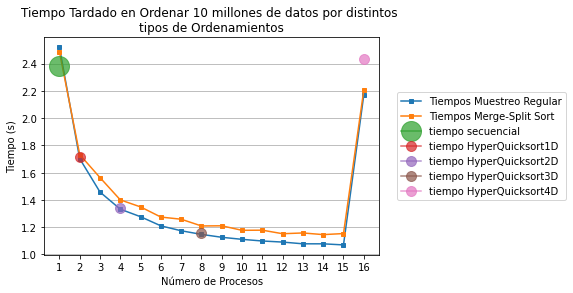

<Figure size 432x288 with 0 Axes>

In [35]:
import matplotlib.pyplot as plt
import numpy as np

tiempo_secuencial = 2.384479
tiempo_hyperquicsort1D = 1.713010
tiempo_hyperquicsort2D = 1.341746
tiempo_hyperquicsort3D = 1.159158
tiempo_hyperquicsort4D = 2.430882

procesos = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

tiempos_mr = np.array([2.5203993758,1.7026435756,1.4577844352,1.3321464392,1.2767404080,
                       1.2098319195,1.1737976708,1.1471510660,1.1258937530,1.1108572837,
                       1.0986478920,1.0907832496,1.0780476662,1.0779096796,1.0699055241,2.1699945088])

tiempos_ms = np.array([2.4884203360,1.7326042363,1.5638709893,1.4004321145,1.3487155987,
                       1.2743167314,1.2584622335,1.2090290836,1.2102296008,1.1770470287,
                       1.1780808242,1.1519941236,1.1576560317,1.1455270066,1.1531990618,2.2060353528])

fig, ax = plt.subplots()
ax.plot(procesos,tiempos_mr,marker='s',label='Tiempos Muestreo Regular',markersize=4)
ax.plot(procesos,tiempos_ms,marker='s',label='Tiempos Merge-Split Sort',markersize=4)

ax.plot([1],[tiempo_secuencial],marker='o',markersize=20,alpha=0.7,label='tiempo secuencial')
ax.plot([2],[tiempo_hyperquicsort1D],marker='o',markersize=10,alpha=0.7,label='tiempo HyperQuicksort1D')
ax.plot([4],[tiempo_hyperquicsort2D],marker='o',markersize=10,alpha=0.7,label='tiempo HyperQuicksort2D')
ax.plot([8],[tiempo_hyperquicsort3D],marker='o',markersize=10,alpha=0.7,label='tiempo HyperQuicksort3D')
ax.plot([16],[tiempo_hyperquicsort4D],marker='o',markersize=10,alpha=0.7,label='tiempo HyperQuicksort4D')

ax.yaxis.grid(True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

plt.xlabel('Número de Procesos')
plt.ylabel('Tiempo (s)')
plt.title('Tiempo Tardado en Ordenar 10 millones de datos por distintos \ntipos de Ordenamientos')

plt.legend(bbox_to_anchor=(1.04, 0.5), loc='center left', ncol=1)
plt.show()


plt.savefig('Tiempos_Hyper.png')
plt.show()

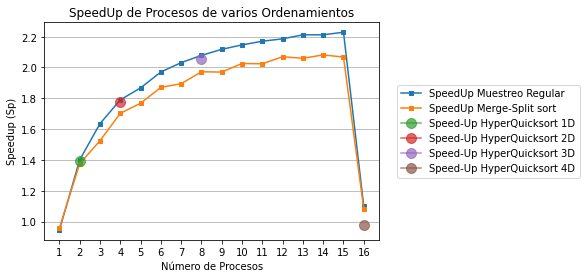

In [36]:
speedup_mr = tiempo_secuencial / tiempos_mr
speedup_ms = tiempo_secuencial / tiempos_ms

speedup_HP1D = tiempo_secuencial / tiempo_hyperquicsort1D
speedup_HP2D = tiempo_secuencial / tiempo_hyperquicsort2D
speedup_HP3D = tiempo_secuencial / tiempo_hyperquicsort3D
speedup_HP4D = tiempo_secuencial / tiempo_hyperquicsort4D


fig, ax = plt.subplots()

ax.plot(procesos,speedup_mr,marker='s',label='SpeedUp Muestreo Regular',markersize=4)
ax.plot(procesos,speedup_ms,marker='s',label='SpeedUp Merge-Split sort',markersize=4)

ax.plot([2],[speedup_HP1D],marker='o',markersize=10,alpha=0.7,label='Speed-Up HyperQuicksort 1D')
ax.plot([4],[speedup_HP2D],marker='o',markersize=10,alpha=0.7,label='Speed-Up HyperQuicksort 2D')
ax.plot([8],[speedup_HP3D],marker='o',markersize=10,alpha=0.7,label='Speed-Up HyperQuicksort 3D')
ax.plot([16],[speedup_HP4D],marker='o',markersize=10,alpha=0.7,label='Speed-Up HyperQuicksort 4D')


ax.yaxis.grid(True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
plt.xlabel('Número de Procesos')
plt.ylabel('Speedup (Sp)')
plt.title('SpeedUp de Procesos de varios Ordenamientos')

plt.legend(bbox_to_anchor=(1.04, 0.5), loc='center left', ncol=1)
plt.savefig('SpeedUp_Hyper.png')
plt.show()

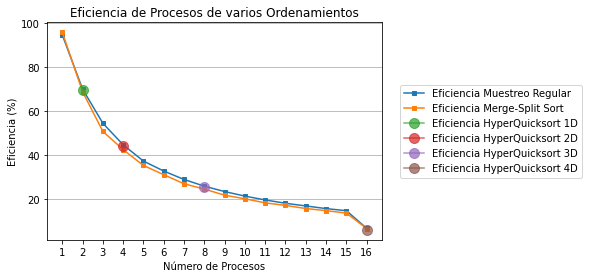

In [37]:
eficiencia_mr = speedup_mr / procesos*100
eficiencia_ms = speedup_ms / procesos*100

eficiencia_HP1D = speedup_HP1D / 2*100
eficiencia_HP2D = speedup_HP2D / 4*100
eficiencia_HP3D = speedup_HP3D / 8*100
eficiencia_HP4D = speedup_HP4D / 16*100

fig, ax = plt.subplots()

ax.plot(procesos,eficiencia_mr,marker='s',label='Eficiencia Muestreo Regular',markersize=4)
ax.plot(procesos,eficiencia_ms,marker='s',label='Eficiencia Merge-Split Sort',markersize=4)

ax.plot([2],[eficiencia_HP1D],marker='o',markersize=10,alpha=0.7,label='Eficiencia HyperQuicksort 1D')
ax.plot([4],[eficiencia_HP2D],marker='o',markersize=10,alpha=0.7,label='Eficiencia HyperQuicksort 2D')
ax.plot([8],[eficiencia_HP3D],marker='o',markersize=10,alpha=0.7,label='Eficiencia HyperQuicksort 3D')
ax.plot([16],[eficiencia_HP4D],marker='o',markersize=10,alpha=0.7,label='Eficiencia HyperQuicksort 4D')

ax.yaxis.grid(True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
plt.xlabel('Número de Procesos')
plt.ylabel('Eficiencia (%)')
plt.title('Eficiencia de Procesos de varios Ordenamientos')

plt.legend(bbox_to_anchor=(1.04, 0.5), loc='center left', ncol=1)
plt.savefig('Eficiencia_Hyper.png')
plt.show()

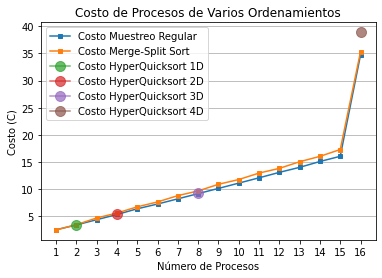

In [38]:
costo_mr = tiempos_mr * procesos
costo_ms = tiempos_ms * procesos

costo_HP1D = tiempo_hyperquicsort1D * 2
costo_HP2D = tiempo_hyperquicsort2D * 4
costo_HP3D = tiempo_hyperquicsort3D * 8
costo_HP4D = tiempo_hyperquicsort4D * 16

fig, ax = plt.subplots()

ax.plot(procesos,costo_mr,marker='s',label='Costo Muestreo Regular',markersize=4)
ax.plot(procesos,costo_ms,marker='s',label='Costo Merge-Split Sort',markersize=4)

ax.plot([2],[costo_HP1D],marker='o',markersize=10,alpha=0.7,label='Costo HyperQuicksort 1D')
ax.plot([4],[costo_HP2D],marker='o',markersize=10,alpha=0.7,label='Costo HyperQuicksort 2D')
ax.plot([8],[costo_HP3D],marker='o',markersize=10,alpha=0.7,label='Costo HyperQuicksort 3D')
ax.plot([16],[costo_HP4D],marker='o',markersize=10,alpha=0.7,label='Costo HyperQuicksort 4D')


ax.yaxis.grid(True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
plt.xlabel('Número de Procesos')
plt.ylabel('Costo (C)')
plt.title('Costo de Procesos de Varios Ordenamientos')

plt.legend()
plt.savefig('Costo_Hyper.png')
plt.show()

In [1]:
%%writefile escritura_paralela.c
#include "mpi.h"
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

#define BLOCK_LOW(id,p,n)  ((id)*(n)/(p))
#define BLOCK_HIGH(id,p,n) (BLOCK_LOW((id)+1,p,n)-1)
#define BLOCK_SIZE(id,p,n) (BLOCK_HIGH(id,p,n)-BLOCK_LOW(id,p,n)+1)
#define BLOCK_OWNER(j,p,n) (((p)*((j)+1)-1)/(n))
//  ■■■■■■■■■■■■■■■■■
int main( int argc, char *argv[] ){
    int i, size, n, rank, count, n_local;
    int *buffer;
    MPI_File fh;
    MPI_Comm comm;
    MPI_Status status;
    MPI_Offset *offset;

    MPI_Init( &argc, &argv );

    comm = MPI_COMM_WORLD;
    MPI_Comm_size( comm, &size );
    MPI_Comm_rank( comm, &rank );

    n = atoi(argv[1]) ;

    n_local = BLOCK_SIZE( rank, size, n );
    printf("\n %d) n=%d n_local = %d\n",rank, n, n_local);

    srand(rank + time(0));
    buffer = (int*)malloc(n_local*sizeof(int)); 
    if(buffer==NULL){ 
      printf("\n ERROR: No hay memoria suficiente (buffer)"); 
      MPI_Finalize(); return 1; 
      }
    for(i=0;i<n_local;i++) 
        buffer[i] = rand()%100;

    offset = (MPI_Offset*)malloc(size*sizeof(MPI_Offset));
    if(offset==NULL){ 
      printf("\n ERROR: No hay memoria suficiente (offset)"); 
      MPI_Finalize(); return 1; 
      }

    offset[0] = sizeof(int);
    for(i=1;i<size;i++)
        offset[i] = offset[i-1] + BLOCK_SIZE( i-1, size, n )*sizeof(int);
 
    MPI_File_open( comm, argv[2] ,MPI_MODE_WRONLY | MPI_MODE_CREATE, MPI_INFO_NULL, &fh);
        if(rank==0) MPI_File_write(fh, &n, 1, MPI_INT, MPI_STATUS_IGNORE); 
       MPI_File_write_at(fh, offset[rank], buffer, n_local, MPI_INT, &status);
    MPI_File_close( &fh );


    for(i=0;i<n_local;i++)
    printf("[%d]%d\t ", rank,buffer[i]);
    printf("\n");    

    MPI_Finalize();
    return 0;
}

Writing escritura_paralela.c


In [2]:
%%script bash
mpicc escritura_paralela.c -o escritura_paralela
mpiexec --allow-run-as-root -np 6 escritura_paralela 20 datos.dat


 1) n=20 n_local = 3

 2) n=20 n_local = 4

 5) n=20 n_local = 4

 4) n=20 n_local = 3

 0) n=20 n_local = 3

 3) n=20 n_local = 3
[3]44	 [3]78	 [3]72	 
[5]54	 [5]59	 [5]26	 [5]70	 
[4]80	 [4]80	 [4]11	 
[2]89	 [2]84	 [2]86	 [2]68	 
[0]21	 [0]65	 [0]69	 
[1]45	 [1]97	 [1]50	 


In [18]:
%%writefile header1.h
//  ¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦
int compare(const void *_a, const void *_b) { 
  int *a, *b;
  
  a = (int *) _a;
  b = (int *) _b;
  return (*a - *b);
}


//  ¦¦¦¦¦¦¦¦¦¦¦¦¦¦
void separaDatos_Pivote(int *bloque,unsigned int *cuantosMn,int **bloqueMenor, unsigned int *cuantosMy,int **bloqueMayor, int pivote, unsigned int n, int iteracion, int id){
	int i;
    *bloqueMenor = NULL;
    *bloqueMayor = NULL;

    *cuantosMn = 0;
    i=0;
	while(bloque[i]<pivote && i<n){
		(*cuantosMn) ++;		
        i++;
    }   

    if(*cuantosMn){
        *bloqueMenor =(int *)malloc((*cuantosMn)*sizeof(int));  if(*bloqueMenor==NULL){printf("\n(%d) ERROR: No hay memoria (*bloqueMenor)\n\n",iteracion);  MPI_Abort(MPI_COMM_WORLD, 99);}
    

        for(i=0;i<*cuantosMn;i++)
            (*bloqueMenor)[i] = bloque[i];
    }
    
    *cuantosMy = n-(*cuantosMn);
    if(*cuantosMy){
        *bloqueMayor =(int *)malloc((*cuantosMy)*sizeof(int));  if(*bloqueMayor==NULL){printf("\n(%d) ERROR: No hay memoria (*bloqueMayor)\n\n",iteracion);  MPI_Abort(MPI_COMM_WORLD, 99);}

        for(i=*cuantosMn;i<n;i++)
            (*bloqueMayor)[i-*cuantosMn]=bloque[i];
    }

	return;
}

//   ¦¦¦¦¦¦¦¦¦¦¦¦¦¦¦
int* mezclar_bloques(int *bloque1,int *bloque2,unsigned int n1,unsigned int n2){ // JOSÉ ALBERTO 
    int *aux;

    aux = (int *)malloc((n1+n2)*sizeof(int));   if(aux==NULL){printf("\n ERROR: No hay memoria (aux)\n\n");  MPI_Abort(MPI_COMM_WORLD, 99);}
    
    unsigned int a = 0; // Indice que recorre el bloque1
    unsigned int b = 0; // Indice que recorre el bloque2
    unsigned int i = 0;

    while (a < n1 && b < n2){
        if(bloque1[a] <= bloque2[b]){
            aux[i] = bloque1[a];
            a++;
        }else{
            aux[i] = bloque2[b];
            b++;
        }
        i++;
    }

    // Si el indice b llegó al final de su arreglo
    if(a == n1){
        // Asignamos los numeros restantes en el bloque2
        while(b < n2){
            aux[i] = bloque2[b];
            b++;
            i++;
        }
    }else   // Si el indice b llegó al final de su arreglo
        // Asignamos los numeros restantes en el bloque1
        while(a < n1){
            aux[i] = bloque1[a];
            a++;
            i++;
        }       

    return aux;
}

Overwriting header1.h


In [19]:
%%writefile Hyperquicksort_ES.c
#include <stdlib.h>
#include "mpi.h"
#include <stdio.h>
#include <math.h> // ceil()
#include <limits.h> // INT_MAX 

#include "header1.h"

#define BLOCK_LOW(id,p,n)  ((id)*(n)/(p))
#define BLOCK_HIGH(id,p,n) (BLOCK_LOW((id)+1,p,n)-1)
#define BLOCK_SIZE(id,p,n) (BLOCK_HIGH(id,p,n)-BLOCK_LOW(id,p,n)+1)
#define BLOCK_OWNER(j,p,n) (((p)*((j)+1)-1)/(n))

int main(int argc, char**argv) {
    int rank, np, root, faltantes;
    unsigned int n,cuantosMn, cuantosMy, cuantosMn2, cuantosMy2, ndatos_local,ndatos_recv,i,j;
    double start, tiempo;
    int  *bloque, *bloqueMenor, *bloqueMayor, *bloqueAux, pivote, partner, nprocesos_minimo;
    MPI_Offset  *offset,*offset2;
    MPI_Status  status;
    MPI_File fh,fh2;
    int idCart, idCart2, pCart;
    int ND, *dimensiones, *periodicos, *recvcounts, *displs;
    int *cambiosDedimension, *cambiosDedimension2;
    MPI_Comm comm_topologia_hipercubo, comm_sub_hipercubo, comm_sub_hipercubo2;


    MPI_Init(&argc, &argv);

    MPI_Comm_size(MPI_COMM_WORLD, &np); // Numero total de procesos
    MPI_Comm_rank(MPI_COMM_WORLD, &rank); // Valor de nuestro identificador
    
    MPI_Barrier(MPI_COMM_WORLD);  // sincronización
    start = MPI_Wtime();

    if(argc!=4){
		if(rank==0) printf("ERROR: mpirun -np <NP> ./hiperquicksort nombre_archivo <NumDimensiones> \n");
		MPI_Abort(MPI_COMM_WORLD,1);
        return EXIT_SUCCESS;
	}
  ND =atoi(argv[3]);

  dimensiones = (int*) malloc(ND*sizeof(int));    
  if( dimensiones == NULL ){ 
    printf("ERROR: Memoria insuficiente! (dimensiones)\n");  
    MPI_Abort(MPI_COMM_WORLD, 99); 
    }
  periodicos = (int*) malloc(ND*sizeof(int));     
  if( periodicos  == NULL ){ 
    printf("ERROR: Memoria insuficiente! (periodicos)\n");   
    MPI_Abort(MPI_COMM_WORLD, 99); 
    }

  nprocesos_minimo = 1; 
    for(i=0;i<ND;i++){
        dimensiones[i]    = 2;
        periodicos[i]     = 0;
        nprocesos_minimo *= 2;
    }

    if( np < nprocesos_minimo ){
        printf( "\nERROR: Se requieren al menos %d procesos \n\n", nprocesos_minimo );
        MPI_Abort( MPI_COMM_WORLD, 99 ); 
    }

    MPI_Cart_create(MPI_COMM_WORLD,ND,dimensiones,periodicos,1,&comm_topologia_hipercubo);

    if(comm_topologia_hipercubo!=MPI_COMM_NULL){
        MPI_Comm_rank(comm_topologia_hipercubo, &idCart);
        MPI_Comm_size(comm_topologia_hipercubo, &pCart);
        root = 0;

    offset = (MPI_Offset*)malloc(np*sizeof(MPI_Offset));
    if(offset==NULL){ 
      printf("\n ERROR: No hay memoria suficiente (offset)"); 
      MPI_Abort(MPI_COMM_WORLD, 99); 
      }
    MPI_File_open( comm_topologia_hipercubo, argv[1], MPI_MODE_RDONLY, MPI_INFO_NULL  , &fh );
        MPI_File_read(fh, &n, 1, MPI_INT, &status);

        offset[0] = sizeof(int);
        for( i = 1 ; i < np ; i++ ) 
            offset[i] = offset[i-1] + BLOCK_SIZE( i-1, np, n )*sizeof(int);

        ndatos_local = BLOCK_SIZE(idCart,pCart,n);

        bloque = (int*)malloc(ndatos_local*sizeof(int)); 
        if( bloque == NULL ){ 
          printf("\n ERROR: No hay memoria suficiente (buffer)"); 
          MPI_Abort(MPI_COMM_WORLD, 99); 
          }
        
        MPI_File_read_at(fh, offset[rank], bloque, ndatos_local, MPI_INT, &status);        
    MPI_File_close(&fh);

    // Cada proceso ordena localmente su bloque
    qsort(bloque, ndatos_local, sizeof(int), &compare);

    // seleccionar un pivote y mandarlo a todo el comunicador
        if( idCart == root ){
            if( ndatos_local % 2 == 0 ) pivote = (bloque[ndatos_local/2]+bloque[(ndatos_local-2)/2])/2; // el promedio de los dos valores medios
            else                        pivote = bloque[ndatos_local/2];
        }
    MPI_Bcast (&pivote, 1, MPI_INT, root, comm_topologia_hipercubo );
    separaDatos_Pivote( bloque, &cuantosMn, &bloqueMenor, &cuantosMy, &bloqueMayor, pivote, ndatos_local, 0 , idCart);      

    cambiosDedimension  = (int*) malloc(ND*sizeof(int));  
    if( cambiosDedimension  == NULL ){ 
      printf("ERROR: Memoria insuficiente! (cambiosDedimension)\n"); 
      MPI_Abort(MPI_COMM_WORLD, 99); 
      }
    cambiosDedimension2 = (int*) malloc(ND*sizeof(int));  
    if( cambiosDedimension2 == NULL ){ 
      printf("ERROR: Memoria insuficiente! (cambiosDedimension2)\n"); 
      MPI_Abort(MPI_COMM_WORLD, 99); 
      }

    for( i = 0 ; i < ND; i++ ){
            for(j=0;j<ND;j++){
                if(j==i){
                    cambiosDedimension[j]=1;				
                    cambiosDedimension2[j]=0;
                }else{
                    cambiosDedimension[j]=0;
                    if(i>j) cambiosDedimension2[j]=0;				
                    else    cambiosDedimension2[j]=1;
                }
            }

            MPI_Cart_sub(comm_topologia_hipercubo, cambiosDedimension, &comm_sub_hipercubo);	// se determina el partner	
            MPI_Comm_rank(comm_sub_hipercubo, &idCart);           

            if(idCart==0){	// envio los mayores al partner y recibo los menores del partner
                partner = 1;			
                MPI_Send(  &cuantosMy, 1, MPI_UNSIGNED, partner, 0, comm_sub_hipercubo          );                
                if( cuantosMy != 0 ){
                    MPI_Send(bloqueMayor, cuantosMy, MPI_INT, partner, 3, comm_sub_hipercubo);
                    free(bloqueMayor);
                }

                MPI_Recv( &cuantosMn2, 1, MPI_UNSIGNED, partner, 1, comm_sub_hipercubo, MPI_STATUS_IGNORE );				
                if( cuantosMn2 != 0 ){				
                    bloqueAux=(int *)malloc(cuantosMn2*sizeof(int));        
                    if( bloqueAux  == NULL ){ 
                      printf("ERROR: Memoria insuficiente! (bloqueAux)\n"); 
                      MPI_Abort(MPI_COMM_WORLD, 99); }		
                    MPI_Recv(bloqueAux, cuantosMn2, MPI_INT, partner, 4, comm_sub_hipercubo, MPI_STATUS_IGNORE);
                }

                if( ndatos_local != 0 )	free(bloque);

                bloque = mezclar_bloques( bloqueMenor, bloqueAux, cuantosMn, cuantosMn2);
                ndatos_local = cuantosMn + cuantosMn2;

                if( cuantosMn  != 0 ) free(bloqueMenor);				
                if( cuantosMn2 != 0 ) free(bloqueAux);
            }else{			
                partner = 0;	
                MPI_Send(&cuantosMn,  1, MPI_UNSIGNED, partner, 1, comm_sub_hipercubo);                
                if(cuantosMn!=0){
                    MPI_Send(bloqueMenor, cuantosMn, MPI_INT, partner, 4, comm_sub_hipercubo);
                    free(bloqueMenor);
                }

                MPI_Recv(&cuantosMy2, 1, MPI_UNSIGNED, partner, 0, comm_sub_hipercubo,  MPI_STATUS_IGNORE);				
                if(cuantosMy2!=0){				
                    bloqueAux=(int *)malloc(cuantosMy2*sizeof(int));        
                    if( bloqueAux  == NULL ){ 
                      printf("ERROR: Memoria insuficiente! (bloqueAux)\n"); 
                      MPI_Abort(MPI_COMM_WORLD, 99); 
                      }	
                    MPI_Recv(bloqueAux, cuantosMy2, MPI_INT, partner, 3, comm_sub_hipercubo,  MPI_STATUS_IGNORE);
                }			
                if( ndatos_local != 0 )	free(bloque);	
                						
                bloque = mezclar_bloques(bloqueMayor, bloqueAux, cuantosMy, cuantosMy2);
                ndatos_local = cuantosMy + cuantosMy2;

                if( cuantosMy  != 0 ) free(bloqueMayor);
                if( cuantosMy2 != 0 ) free(bloqueAux);
            }
        
            if(i!=ND-1){ // se divide en subcomunicadores
                MPI_Cart_sub( comm_topologia_hipercubo, cambiosDedimension2, &comm_sub_hipercubo2 );		
                MPI_Comm_rank( comm_sub_hipercubo2, &idCart2 );
                if(idCart2==0){
                    if( ndatos_local > 0 ){
                        if(ndatos_local%2==0) pivote = (bloque[ndatos_local/2]+bloque[(ndatos_local-2)/2])/2; // el promedio de los dos valores medios
                        else                  pivote = bloque[ndatos_local/2];
                    }else{
                        printf("\n ERROR: El root se quedó sin datos :( <==== \n\n");
                        MPI_Abort(MPI_COMM_WORLD, 99);
                    }
                }				
                MPI_Bcast(&pivote,1,MPI_INT,0,comm_sub_hipercubo2);	
                separaDatos_Pivote( bloque, &cuantosMn, &bloqueMenor, &cuantosMy, &bloqueMayor, pivote, ndatos_local, i , idCart);
            }	       
        }

        if(ND>1){
            MPI_Comm_free(&comm_sub_hipercubo);
            MPI_Comm_free(&comm_sub_hipercubo2);
        }

        MPI_Comm_rank(comm_topologia_hipercubo, &idCart);
        MPI_Comm_size(comm_topologia_hipercubo, &pCart);
        
        if(idCart==root){
            recvcounts = (unsigned int*) malloc(pCart*sizeof(unsigned int));  
            if( recvcounts  == NULL ){ 
              printf("ERROR: Memoria insuficiente! (recvcounts)\n"); 
              MPI_Abort(MPI_COMM_WORLD, 99); 
            }
        }

        MPI_Gather( &ndatos_local, 1,   MPI_UNSIGNED, recvcounts, 1, MPI_UNSIGNED, root , comm_topologia_hipercubo );
        displs = (unsigned int*)malloc(pCart*sizeof(unsigned int));       
        if( displs     == NULL ){ 
          printf("ERROR: Memoria insuficiente (displs)");         
          MPI_Abort(MPI_COMM_WORLD,99);  
          } 

        if(idCart==root){
          displs[0] = 0; 
            for( i = 1 ; i < pCart ; i++ ) 
                displs[i] = displs[i-1] + recvcounts[i-1]; 
        }   

    offset2 = (MPI_Offset*)malloc(np*sizeof(MPI_Offset));
    if(offset==NULL){ 
      printf("\n ERROR: No hay memoria suficiente (offset)"); 
      MPI_Finalize(); return 1; 
      }        
    MPI_Bcast(displs, np, MPI_UNSIGNED, root, comm_topologia_hipercubo);
    for(i=0;i<np;i++){
        offset2[i] = (displs[i] + 1)*sizeof(int);
    }

     MPI_File_open( MPI_COMM_WORLD, argv[2] ,MPI_MODE_WRONLY | MPI_MODE_CREATE, MPI_INFO_NULL, &fh2);
        if(rank==0) MPI_File_write(fh2, &n, 1, MPI_INT, MPI_STATUS_IGNORE); 
      MPI_File_write_at(fh2, offset2[rank], bloque, ndatos_local, MPI_INT, &status);
    MPI_File_close( &fh2);


      // <--- toma de tiempo 2
    tiempo = MPI_Wtime() - start;

     MPI_Comm_free(&comm_topologia_hipercubo);
     free(bloque);
     free(offset);
     free(offset2);
     free(dimensiones);
     free(periodicos);
     free(displs);
     free(cambiosDedimension);
     free(cambiosDedimension2);
     if(rank == root){
         free(recvcounts);
     }
    if(rank==root)
       printf("%d\t%.10f\n", np,tiempo);
  }
    MPI_Finalize();
    return 0;
}

Overwriting Hyperquicksort_ES.c


In [24]:
%%script bash
mpicc Hyperquicksort_ES.c -o Hyperquicksort_ES -lm
mpirun --allow-run-as-root   -np 4 ./Hyperquicksort_ES datos.dat datos_ordenados.dat 2

4	0.2639149420


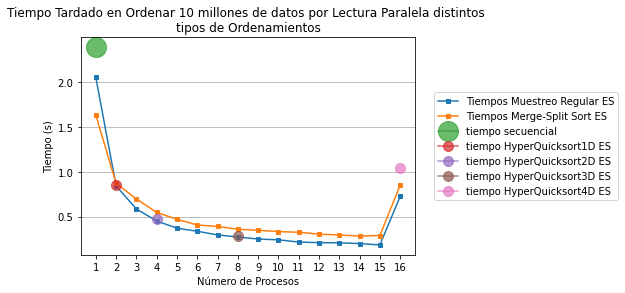

<Figure size 432x288 with 0 Axes>

In [27]:
import matplotlib.pyplot as plt
import numpy as np

tiempo_secuencial = 2.384479
tiempo_hyperquicksort1D_ES = 0.8560240846
tiempo_hyperquicksort2D_ES = 0.4720100425
tiempo_hyperquicksort3D_ES = 0.2902922966
tiempo_hyperquicksort4D_ES = 1.0400099568

procesos = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

tiempos_mr_ES = np.array([2.0480481386,0.8412544075,0.5850097258,0.4517658949,0.3714222554,
                          0.3375743050,0.2969053462,0.2736739647,0.2511777710,0.2420908529,
                          0.2176377308,0.2108902540,0.2086369917,0.2004519235,0.1856392194,0.7263396773])

tiempos_ms_ES = np.array([1.6291406602,0.8698859699,0.6976922750,0.5469680410,0.4702280164,
                          0.4074583687,0.3908164091,0.3605576288,0.3485211879,0.3341951221,
                          0.3260014467,0.3057997487,0.2957764994,0.2846506201,0.2901635487,0.8503531665])

fig, ax = plt.subplots()
ax.plot(procesos,tiempos_mr_ES,marker='s',label='Tiempos Muestreo Regular ES',markersize=4)
ax.plot(procesos,tiempos_ms_ES,marker='s',label='Tiempos Merge-Split Sort ES',markersize=4)

ax.plot([1],[tiempo_secuencial],marker='o',markersize=20,alpha=0.7,label='tiempo secuencial')
ax.plot([2],[tiempo_hyperquicksort1D_ES],marker='o',markersize=10,alpha=0.7,label='tiempo HyperQuicksort1D ES')
ax.plot([4],[tiempo_hyperquicksort2D_ES],marker='o',markersize=10,alpha=0.7,label='tiempo HyperQuicksort2D ES')
ax.plot([8],[tiempo_hyperquicksort3D_ES],marker='o',markersize=10,alpha=0.7,label='tiempo HyperQuicksort3D ES')
ax.plot([16],[tiempo_hyperquicksort4D_ES],marker='o',markersize=10,alpha=0.7,label='tiempo HyperQuicksort4D ES')

ax.yaxis.grid(True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

plt.xlabel('Número de Procesos')
plt.ylabel('Tiempo (s)')
plt.title('Tiempo Tardado en Ordenar 10 millones de datos por Lectura Paralela distintos \ntipos de Ordenamientos')

plt.legend(bbox_to_anchor=(1.04, 0.5), loc='center left', ncol=1)
plt.show()


plt.savefig('Tiempos_Hyper_ES.png')
plt.show()

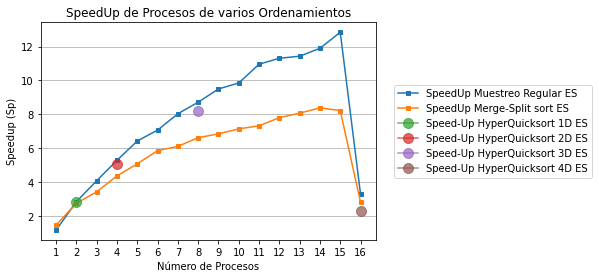

In [31]:
speedup_mr_ES = tiempo_secuencial / tiempos_mr_ES
speedup_ms_ES = tiempo_secuencial / tiempos_ms_ES

speedup_HP1D_ES = tiempo_secuencial / tiempo_hyperquicksort1D_ES
speedup_HP2D_ES = tiempo_secuencial / tiempo_hyperquicksort2D_ES
speedup_HP3D_ES = tiempo_secuencial / tiempo_hyperquicksort3D_ES
speedup_HP4D_ES = tiempo_secuencial / tiempo_hyperquicksort4D_ES


fig, ax = plt.subplots()

ax.plot(procesos,speedup_mr_ES,marker='s',label='SpeedUp Muestreo Regular ES',markersize=4)
ax.plot(procesos,speedup_ms_ES,marker='s',label='SpeedUp Merge-Split sort ES',markersize=4)

ax.plot([2],[speedup_HP1D_ES],marker='o',markersize=10,alpha=0.7,label='Speed-Up HyperQuicksort 1D ES')
ax.plot([4],[speedup_HP2D_ES],marker='o',markersize=10,alpha=0.7,label='Speed-Up HyperQuicksort 2D ES')
ax.plot([8],[speedup_HP3D_ES],marker='o',markersize=10,alpha=0.7,label='Speed-Up HyperQuicksort 3D ES')
ax.plot([16],[speedup_HP4D_ES],marker='o',markersize=10,alpha=0.7,label='Speed-Up HyperQuicksort 4D ES')


ax.yaxis.grid(True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
plt.xlabel('Número de Procesos')
plt.ylabel('Speedup (Sp)')
plt.title('SpeedUp de Procesos de varios Ordenamientos')

plt.legend(bbox_to_anchor=(1.04, 0.5), loc='center left', ncol=1)
plt.savefig('SpeedUp_Hyper_ES.png')
plt.show()

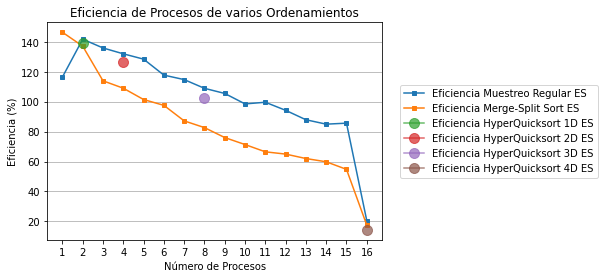

In [32]:
eficiencia_mr_ES = speedup_mr_ES / procesos*100
eficiencia_ms_ES = speedup_ms_ES / procesos*100

eficiencia_HP1D_ES = speedup_HP1D_ES / 2*100
eficiencia_HP2D_ES = speedup_HP2D_ES / 4*100
eficiencia_HP3D_ES = speedup_HP3D_ES / 8*100
eficiencia_HP4D_ES = speedup_HP4D_ES / 16*100

fig, ax = plt.subplots()

ax.plot(procesos,eficiencia_mr_ES,marker='s',label='Eficiencia Muestreo Regular ES',markersize=4)
ax.plot(procesos,eficiencia_ms_ES,marker='s',label='Eficiencia Merge-Split Sort ES',markersize=4)

ax.plot([2],[eficiencia_HP1D_ES],marker='o',markersize=10,alpha=0.7,label='Eficiencia HyperQuicksort 1D ES')
ax.plot([4],[eficiencia_HP2D_ES],marker='o',markersize=10,alpha=0.7,label='Eficiencia HyperQuicksort 2D ES')
ax.plot([8],[eficiencia_HP3D_ES],marker='o',markersize=10,alpha=0.7,label='Eficiencia HyperQuicksort 3D ES')
ax.plot([16],[eficiencia_HP4D_ES],marker='o',markersize=10,alpha=0.7,label='Eficiencia HyperQuicksort 4D ES')

ax.yaxis.grid(True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
plt.xlabel('Número de Procesos')
plt.ylabel('Eficiencia (%)')
plt.title('Eficiencia de Procesos de varios Ordenamientos')

plt.legend(bbox_to_anchor=(1.04, 0.5), loc='center left', ncol=1)
plt.savefig('Eficiencia_Hyper_ES.png')
plt.show()

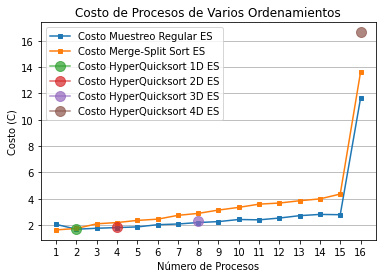

In [34]:
costo_mr_ES = tiempos_mr_ES * procesos
costo_ms_ES = tiempos_ms_ES * procesos

costo_HP1D_ES = tiempo_hyperquicksort1D_ES * 2
costo_HP2D_ES = tiempo_hyperquicksort2D_ES * 4
costo_HP3D_ES = tiempo_hyperquicksort3D_ES * 8
costo_HP4D_ES = tiempo_hyperquicksort4D_ES * 16

fig, ax = plt.subplots()

ax.plot(procesos,costo_mr_ES,marker='s',label='Costo Muestreo Regular ES',markersize=4)
ax.plot(procesos,costo_ms_ES,marker='s',label='Costo Merge-Split Sort ES',markersize=4)

ax.plot([2],[costo_HP1D_ES],marker='o',markersize=10,alpha=0.7,label='Costo HyperQuicksort 1D ES')
ax.plot([4],[costo_HP2D_ES],marker='o',markersize=10,alpha=0.7,label='Costo HyperQuicksort 2D ES')
ax.plot([8],[costo_HP3D_ES],marker='o',markersize=10,alpha=0.7,label='Costo HyperQuicksort 3D ES')
ax.plot([16],[costo_HP4D_ES],marker='o',markersize=10,alpha=0.7,label='Costo HyperQuicksort 4D ES')


ax.yaxis.grid(True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
plt.xlabel('Número de Procesos')
plt.ylabel('Costo (C)')
plt.title('Costo de Procesos de Varios Ordenamientos')

plt.legend()
plt.savefig('Costo_Hyper_ES.png')
plt.show()